# HW 4.Сравнение автоэнкодеров и ResNet репрезентаций

В этом задании, вам предлагается сравнить эмбеддинги картинок, принадлежащих различным классам из CIFAR-10. Для сравнения, предлагается рассмотреть эмбеддинги, полученные из обученного классификатора, и эмбеддинги из автоэнкодера.

Вам нужно реализовать следующие функции:
- Извлечение эмбеддингов из предобученного классификатора;
- Снижение размерности эмбеддингов с помощью PCA;
- Обучение автоэнкодера и извлечение его признаков;
- Написание функции визуализации

# 1. Загрузка CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert PIL image to Tensor and scale to [0,1]
    ]
)

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# Create DataLoader for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=777, strict=False):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if strict:
        if hasattr(torch, 'use_deterministic_algorithms'):
            torch.use_deterministic_algorithms(True)
        print("Strict deterministic behavior enabled.")
    else:
        if hasattr(torch, 'use_deterministic_algorithms'):
            torch.use_deterministic_algorithms(False)
        print("Strict deterministic behavior disabled.")

    print(f"Seed fixed: {seed}")

set_seed(777)

Strict deterministic behavior disabled.
Seed fixed: 777


# 2. Загрузка предобученной модели

В данной задаче от вас не требуется обучать новую модель. Мы воспользуемся предобученной модели ResNet18 на ImageNet. Под эмбеддингом будем понимать вектор, полученный до последнего слоя классификации.

In [3]:
from torchvision.models import resnet18, ResNet18_Weights

# Загрузите веса модели
classificator = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Измените размерность выхода классификатора на 10, чтобы запустить модель
# На месте ... должна стоять размерность эмбеддинга из оригинальной модели
classificator.fc = nn.Linear(512, 10)  
# Заморозьте веса, тк мы не хотим тренеровать их
for param in classificator.parameters():
    param.requires_grad = False

In [4]:
# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddigns = []
# Сохраняем классы эмбеддингов
classes = []


def hook_fn(module, input, output):
    batch_embeddings = output.view(output.size(0), -1).detach().cpu().numpy()
    embeddigns.append(batch_embeddings)


hook = classificator.avgpool.register_forward_hook(hook_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classificator.to(device)
classificator.eval()

for i, (images, labels) in enumerate(test_loader):
    # Передайте картинки в модель
    # Извлеките эмбеддинги. Например, можно воспользоваться хуками:
    # https://discuss.pytorch.org/t/issue-with-registering-forward-hooks-in-a-transformer/181500
    # Сохраните эмбеддинги для последующей визуализации
    if i >= max_steps:
        break

    with torch.no_grad():
        images = images.to(device)
        classificator(images)
        classes.append(labels.numpy())
hook.remove()

In [5]:
import numpy as np

embeddigns = np.concatenate(embeddigns, axis=0)
classes = np.concatenate(classes, axis=0)

print(embeddigns.shape, classes.shape)

(100, 512) (100,)


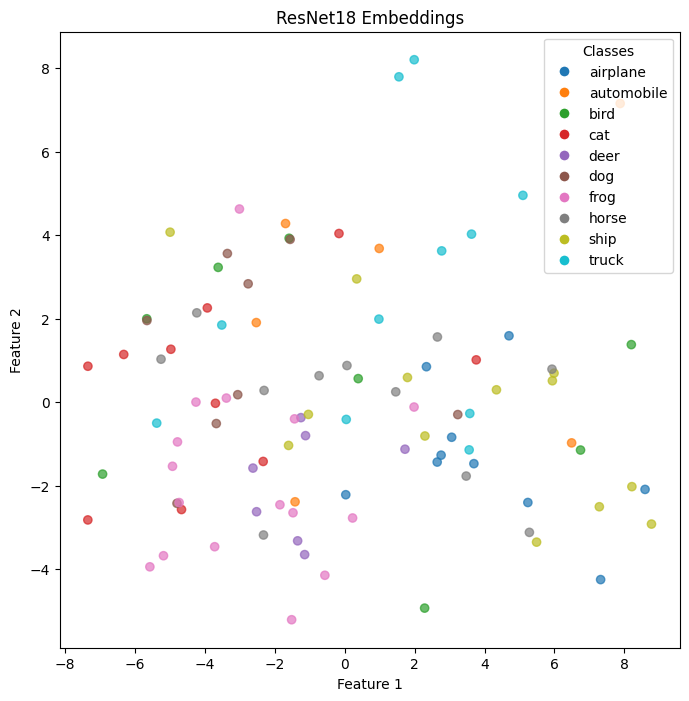

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

# Передайте эмбеддинги в PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddigns)


def show_embeddings(embeddings, labels, title):
    class_names = train_dataset.classes
    cmap = plt.cm.tab10

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap=cmap, alpha=0.7)
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=class_names[i],
            markerfacecolor=cmap(i),
            markersize=8,
        )
        for i in range(len(class_names))
    ]

    plt.legend(handles=legend_elements, title="Classes")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# Визуализируем эмбеддинги, с учетом их классов
show_embeddings(pca_result, classes, "ResNet18 Embeddings")

# 3. Обучение автоэнкодера

В данной реализации приведен не очень хороший, но рабочий автоэнкодер. Его уже придется обучить на тренировочном датасете

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=768,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=latent_dim),
            nn.LeakyReLU(0.1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(in_features=latent_dim,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=768),
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, 1)
        encoded = self.linear1(encoded)

        decoded = self.linear2(encoded)
        decoded = decoded.reshape(-1,48,4,4)
        decoded = self.decoder(decoded)
        return decoded

    def encode(self, x):
      encoded = self.encoder(x)

      encoded = torch.flatten(encoded, 1)
      encoded = self.linear1(encoded)
      return encoded

In [8]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [9]:
autoencoder.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.6351
Epoch [2/10], Loss: 0.6405
Epoch [3/10], Loss: 0.6604
Epoch [4/10], Loss: 0.6508
Epoch [5/10], Loss: 0.6216
Epoch [6/10], Loss: 0.6410
Epoch [7/10], Loss: 0.6102
Epoch [8/10], Loss: 0.6259
Epoch [9/10], Loss: 0.6292
Epoch [10/10], Loss: 0.6323


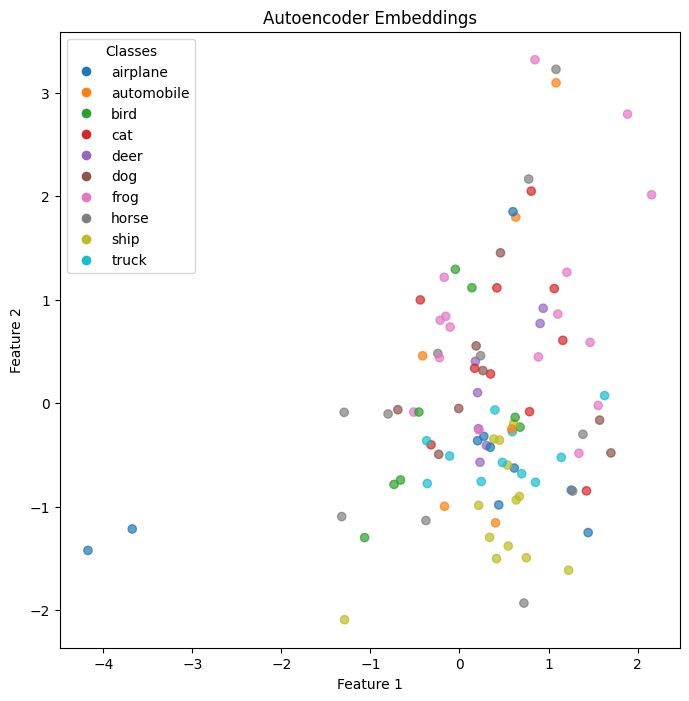

In [10]:
# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddigns = []
# Сохраняем классы эмбеддингов
classes = []

autoencoder.eval()
for i, (images, labels) in enumerate(test_loader):
    # Вызовите часть энкодера для получения эмбеддингов размерности 2
    # Здесь не требуется никаких хуков и PCA
    if i >= max_steps:
        break

    with torch.no_grad():
        images = images.to(device)
        batch_embeddings = autoencoder.encode(images).detach().cpu().numpy()
        embeddigns.append(batch_embeddings)
        classes.append(labels.numpy())

embeddigns = np.concatenate(embeddigns, axis=0)
classes = np.concatenate(classes, axis=0)

# Повторите этап с визуализацией из предыдущего пункта
show_embeddings(embeddigns, classes, "Autoencoder Embeddings")